In [ ]:
!pip install gym
!pip install stable-baselines3
!pip install gym-super-mario-bros
!pip install opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.1 MB/s eta 0:00:00
  Created wheel for nes-py: filename=nes_py-8.2.1-cp310-cp310-linux_x86_64.whl size=535719 sha256=138c60ea54bdb0471862643c1ad295bd908fa52d5149e3b8839be993e53b0b35
  Stored in directory: /root/.cache/pip/wheels/34/a7/d5/9aa14b15df740a53d41f702e4c795731b6c4da7925deb8476c
Successfully built nes-py


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import gym
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT


class smb_grid:

    def __init__(self, env):
        self.ram = env.unwrapped.ram
        self.screen_size_x = 16     # rendered screen size
        self.screen_size_y = 13

        self.mario_level_x = self.ram[0x6d]*256 + self.ram[0x86]
        self.mario_x = self.ram[0x3ad]  # mario's position on the rendered screen
        self.mario_y = self.ram[0x3b8] + 16 # top edge of (big) mario

        self.x_start = self.mario_level_x - self.mario_x # left edge pixel of the rendered screen in level
        self.rendered_screen = self.get_rendered_screen()


    ########
    # get background tile grid

    def tile_loc_to_ram_address(self, x, y):
        '''
        convert (x, y) in Current tile (32x13, stored as 16x26 in ram) to ram address
        x: 0 to 31
        y: 0 to 12
        '''
        page = x // 16
        x_loc = x%16
        y_loc = page*13 + y

        address = 0x500 + x_loc + y_loc*16

        return address

    def get_rendered_screen(self):
        '''
        Get the rendered screen (16 x 13) from ram
        empty: 0
        tile: 1
        enemy: -1
        mario: 2
        '''

        # Get background tiles

        rendered_screen = np.zeros((self.screen_size_y, self.screen_size_x))
        screen_start = int(np.rint(self.x_start / 16))

        for i in range(self.screen_size_x):
            for j in range(self.screen_size_y):
                x_loc = (screen_start + i) % (self.screen_size_x * 2)
                y_loc = j
                address = self.tile_loc_to_ram_address(x_loc, y_loc)
                #bg_screen2[j, i] = env.unwrapped.ram[address]

                # Convert all types of tile to 1
                if self.ram[address] != 0:
                    rendered_screen[j, i] = 1

        # Add mario
        x_loc = (self.mario_x + 8) // 16
        y_loc = (self.mario_y - 32) // 16 # top 2 rows in the rendered screen aren't stored in ram
        if x_loc < 16 and y_loc < 13:
            rendered_screen[y_loc, x_loc] = 2

        # Add enemies
        for i in range(5):
            # check if the enemy is drawn
            if self.ram[0xF + i] == 1:
                enemy_x = self.ram[0x6e + i]*256 + self.ram[0x87 + i] - self.x_start
                enemy_y = self.ram[0xcf + i]
                x_loc = (enemy_x + 8) // 16
                y_loc = (enemy_y + 8 - 32) // 16

                # check if the enemy is inside the rendered screen
                # 8/6/22 fixed bug where enemy with x_loc < 0 still got added to rendered_screen; doesn't seem to affect trained models' performance
                # if x_loc < 16 and y_loc < 13:
                if 0 <= x_loc < 16 and 0 <= y_loc < 13:
                    rendered_screen[y_loc, x_loc] = -1

        return rendered_screen

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
"""

# Define custom environment to crop obs frame
from gym import spaces
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY
from nes_py.wrappers import JoypadSpace

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.policies import obs_as_tensor



import time

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation

import imageio


class SMBRamWrapper(gym.ObservationWrapper):
    def __init__(self, env, crop_dim=[0, 16, 0, 13], n_stack=4, n_skip=2):
        '''
        crop_dim: [x0, x1, y0, y1]
        obs shape = (height, width, n_stack), n_stack=0 is the most recent frame
        n_skip: e.g. n_stack=4, n_skip=2, use frames [0, 2, 4, 6]
        '''
        gym.Wrapper.__init__(self, env)
        self.crop_dim = crop_dim
        self.n_stack = n_stack
        self.n_skip = n_skip
        # Modified from stable_baselines3.common.atari_wrappers.WarpFrame()
        # https://stable-baselines3.readthedocs.io/en/master/_modules/stable_baselines3/common/atari_wrappers.html#AtariWrapper
        self.width = crop_dim[1] - crop_dim[0]
        self.height = crop_dim[3] - crop_dim[2]
        self.observation_space = spaces.Box(
            low=-1, high=2, shape=(self.height, self.width, self.n_stack), dtype=int
        )

        self.frame_stack = np.zeros((self.height, self.width, (self.n_stack-1)*self.n_skip+1))
        #self.INDEX_SKIP = 1

    def observation(self, obs):
        grid = smb_grid(self.env)
        frame = grid.rendered_screen # 2d array
        frame = self.crop_obs(frame)

        self.frame_stack[:,:,1:] = self.frame_stack[:,:,:-1] # shift frame_stack by 1
        self.frame_stack[:,:,0] = frame # add current frame to stack
        obs = self.frame_stack[:,:,::self.n_skip]
        return obs

    def reset(self):
        obs = self.env.reset()
        self.frame_stack = np.zeros((self.height, self.width, (self.n_stack-1)*self.n_skip+1))
        grid = smb_grid(self.env)
        frame = grid.rendered_screen # 2d array
        frame = self.crop_obs(frame)
        for i in range(self.frame_stack.shape[-1]):
            self.frame_stack[:,:,i] = frame
        obs = self.frame_stack[:,:,::self.n_skip]
        return obs

    def crop_obs(self, im):
        '''
        Crop observed frame image to reduce input size
        Returns cropped_frame = original_frame[y0:y1, x0:x1]
        '''
        [x0, x1, y0, y1] = self.crop_dim
        im_crop = im[y0:y1, x0:x1]
        return im_crop


def load_smb_env(name='SuperMarioBros-1-1-v0', crop_dim=[0,16,0,13], n_stack=2, n_skip=4):
    '''
    Wrapper function for loading and processing smb env
    '''
    env = gym_super_mario_bros.make(name)
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    env_wrap = SMBRamWrapper(env, crop_dim, n_stack=n_stack, n_skip=n_skip)
    env_wrap = DummyVecEnv([lambda: env_wrap])

    return env_wrap


class SMB():
    '''
    Wrapper function containing the processed environment and the loaded model
    '''
    def __init__(self, env, model):
        self.env = env
        self.model = model

    def play(self, episodes=5, deterministic=False, render=True, return_eval=False):
        for episode in range(1, episodes+1):
            states = self.env.reset()
            done = False
            score = 0

            if render == True:
                while not done:
                    self.env.render()
                    action, _ = self.model.predict(states, deterministic=deterministic)
                    states, reward, done, info = self.env.step(action)
                    score += reward
                    time.sleep(0.01)
                print('Episode:{} Score:{}'.format(episode, score))
            else:
                while not done:
                    action, _ = self.model.predict(states, deterministic=deterministic)
                    states, reward, done, info = self.env.step(action)
                    score += reward
        if return_eval == True:
            return score, info
        else:
            return

    def evaluate(self, episodes=20, deterministic=False):
        '''
        returns rewards, steps (both have length [episodes])
        '''
        rewards, steps = evaluate_policy(self.model, self.env, n_eval_episodes=episodes,
                                 deterministic=deterministic, render=False,
                                 return_episode_rewards=True)
        return rewards, steps

    import numpy as np


    def predict_proba(self, state):
        '''
        Predict the probability of each action given a state
        https://stackoverflow.com/questions/66428307/how-to-get-action-propability-in-stable-baselines-3/70012691#70012691?newreg=bd5479b970664069b359903e0151b4a1
        '''
        model = self.model
        obs = obs_as_tensor(state, model.policy.device)
        dis = model.policy.get_distribution(obs)
        probs = dis.distribution.probs
        probs_np = probs.detach().numpy()
        return probs_np

    #############
    # functions for making plots & videos

    def make_video_frames(self, deterministic=False):
        '''
        For each step, plot obs & rendered screen in one figure for making videoes
        '''
        state = self.env.reset()
        done = False
        score = [0]
        #self._make_combined_plot2(state, score, prob_actions)
        #self._make_combined_plot(state, score)


        while not done:
        #for i in range(1):
            prob_actions = self.predict_proba(state)
            action, _ = self.model.predict(state, deterministic=deterministic)
            state, reward, done, info = self.env.step(action)
            score += reward
            self._make_combined_plot2(state, score, prob_actions)
            #self._make_combined_plot(state, score)


    def _make_combined_plot2(self, state, score, prob_actions):
        '''
        Originally made for n_stack = 4 & n_skip = 4, SIMPLE_MOVEMENT
        '''
        # get rendered screen
        im_render = self.env.render(mode="rgb_array")

        n_stack = state.shape[-1]
        cmap = colors.ListedColormap(['red', 'skyblue', 'brown', 'blue'])
        bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        #obs_loc = [[0, 1], [0, 2], [1, 1], [1, 2]]
        obs_loc = [[0, 1], [1, 1], [2, 1], [3, 1]]
        obs_text = ['t (current frame)', 't-4', 't-8', 't-12']
        action_list = ['NOOP', 'right', 'right+A', 'right+B', 'right+A+B', 'A', 'left']


        ##########
        fig = plt.figure(dpi=100, figsize=(6, 6), constrained_layout=False, tight_layout=True)
        gs = fig.add_gridspec(4, 2, width_ratios=[3, 1])

        # individual obs frames
        for n in range(n_stack):
            ax = fig.add_subplot(gs[obs_loc[n][0], obs_loc[n][1]])
            im = ax.imshow(state[0,:,:,n], cmap=cmap, norm=norm)
            ax.set_axis_off()
            ax.text(-0.5, 14.5, obs_text[n])

        # prob_actions
        ax = fig.add_subplot(gs[3, 0])
        ax.bar(action_list, prob_actions[0])
        plt.xticks(rotation=45)
        ax.set_ylim(0, 1.05)

        # rendered screen
        ax = fig.add_subplot(gs[0:3, 0])
        im = ax.imshow(im_render)
        ax.set_axis_off()
        ax.text(0, -5, 'score: '+str(int(score[0])))

        plt.show()


    def _make_combined_plot(self, state, score):
        # get rendered screen
        im_render = self.env.render(mode="rgb_array")
        n_stack = state.shape[-1]

        cmap = colors.ListedColormap(['red', 'skyblue', 'brown', 'blue'])
        bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        #obs_text = ['t (current frame)', 't-4', 't-8', 't-12']

        fig = plt.figure(dpi=100, figsize=(5.5, 4), constrained_layout=False, tight_layout=True)
        gs = fig.add_gridspec(4, 2, width_ratios=[4, 1])

        # individual obs frames
        for n in range(n_stack):
            ax = fig.add_subplot(gs[n, 1])
            im = ax.imshow(states[0,:,:,n], cmap=cmap, norm=norm)
            ax.set_axis_off()

        # rendered screen
        ax = fig.add_subplot(gs[:, 0])
        im = ax.imshow(im_render)
        ax.set_axis_off()
        ax.text(0, -5, 'score: '+str(int(score[0])))

        plt.show()

    def make_animation(self, deterministic=True, filename='gym_animation.gif', RETURN_FRAMES=False):
        '''
        Make an animation of the rendered screen
        '''
        # run policy
        frames = []
        states = self.env.reset()
        done = False

        while not done:
            #frames.append(self.env.render(mode="rgb_array"))
            im = self.env.render(mode="rgb_array")
            frames.append(im.copy())
            action, _ = self.model.predict(states, deterministic=deterministic)
            states, reward, done, info = self.env.step(action)

        if RETURN_FRAMES == False:
            # make animation
            imageio.mimsave(filename, frames, fps=50)
        else: # make animation manually in case Mario gets stuck in the level and drags the animation for too long
            return frames

In [ ]:
from nes_py.wrappers import JoypadSpace
import gym
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnv, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

import time
import matplotlib.pyplot as plt

env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)



/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


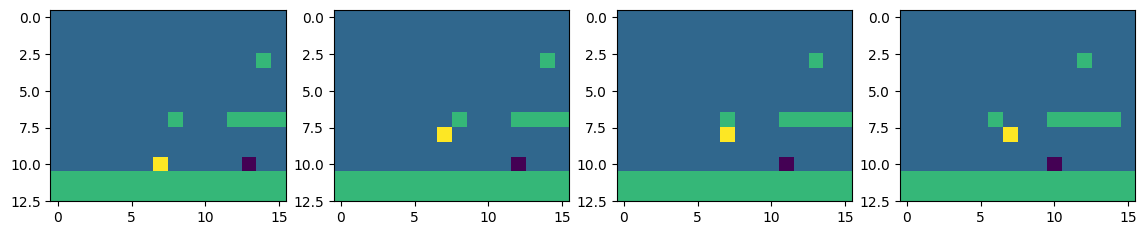

In [ ]:
# Setup cropping size
x0 = 0
x1 = 16
y0 = 0
y1 = 13
n_stack = 4
n_skip = 4

env_wrap = SMBRamWrapper(env, [x0, x1, y0, y1], n_stack=n_stack, n_skip=n_skip)

# test env_wrap
done = True
for i in range(150):
    if done:
        state = env_wrap.reset()
    state, reward, done, info = env_wrap.step(env_wrap.action_space.sample())

state.shape

(13, 16, 4)

fig, ax = plt.subplots(1, n_stack, figsize=(14,10))
for i in range(n_stack):
    ax[i].imshow(state[:,:,n_stack-i-1], vmin=-1, vmax=2)
plt.show()



In [ ]:
# Apply other wrapper functions
env_wrap = Monitor(env_wrap)  # for tensorboard log
env_wrap = DummyVecEnv([lambda: env_wrap])

In [ ]:
# Callbacks

# Save intermediate models
# Copied from Nicholas Renotte's code
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path,
                 starting_steps=0, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        self.starting_steps = starting_steps

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls + int(self.starting_steps)))
            self.model.save(model_path)

        return True

# Linear learning rate schedule
# https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#learning-rate-schedule
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

In [ ]:
### MODIFY THESE TWO DIRECTORIES BEFORE TRAINING A NEW MODEL ###
MODEL_DIR = './models/NEW_MODEL_DIR'
LOG_DIR = './logs/NEW_LOG_DIR'

In [ ]:
# import dependencies
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnv
from stable_baselines3.common.evaluation import evaluate_policy

import os

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving pre-trained-1.zip to pre-trained-1.zip


In [ ]:
# Select a pre-trained model
#MODEL_DIR = './models'

# obs = 4 frames
crop_dim = [0, 16, 0, 13]
n_stack = 4
n_skip = 4
MODEL_NAME = 'pre-trained-1'


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# load env and model
env_wrap = load_smb_env('SuperMarioBros-1-1-v0', crop_dim, n_stack, n_skip)
model = PPO(MODEL_NAME, env=env_wrap)
smb = SMB(env_wrap, model)

ValueError: ignored

In [ ]:
smb.play(episodes=1, deterministic=True, render=True, return_eval=True)

In [ ]:
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
#Import everything needed to edit/save/watch video clips
from moviepy import editor
import moviepy

def region_selection(image):
	"""
	Determine and cut the region of interest in the input image.
	Parameters:
		image: we pass here the output from canny where we have
		identified edges in the frame
	"""
	# create an array of the same size as of the input image
	mask = np.zeros_like(image)
	# if you pass an image with more then one channel
	if len(image.shape) > 2:
		channel_count = image.shape[2]
		ignore_mask_color = (255,) * channel_count
	# our image only has one channel so it will go under "else"
	else:
		# color of the mask polygon (white)
		ignore_mask_color = 255
	# creating a polygon to focus only on the road in the picture
	# we have created this polygon in accordance to how the camera was placed
	rows, cols = image.shape[:2]
	bottom_left = [cols * 0.1, rows * 0.95]
	top_left	 = [cols * 0.4, rows * 0.6]
	bottom_right = [cols * 0.9, rows * 0.95]
	top_right = [cols * 0.6, rows * 0.6]
	vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
	# filling the polygon with white color and generating the final mask
	cv2.fillPoly(mask, vertices, ignore_mask_color)
	# performing Bitwise AND on the input image and mask to get only the edges on the road
	masked_image = cv2.bitwise_and(image, mask)
	return masked_image

def hough_transform(image):
	"""
	Determine and cut the region of interest in the input image.
	Parameter:
		image: grayscale image which should be an output from the edge detector
	"""
	# Distance resolution of the accumulator in pixels.
	rho = 1
	# Angle resolution of the accumulator in radians.
	theta = np.pi/180
	# Only lines that are greater than threshold will be returned.
	threshold = 20
	# Line segments shorter than that are rejected.
	minLineLength = 20
	# Maximum allowed gap between points on the same line to link them
	maxLineGap = 500
	# function returns an array containing dimensions of straight lines
	# appearing in the input image
	return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
						minLineLength = minLineLength, maxLineGap = maxLineGap)

def average_slope_intercept(lines):
	"""
	Find the slope and intercept of the left and right lanes of each image.
	Parameters:
		lines: output from Hough Transform
	"""
	left_lines = [] #(slope, intercept)
	left_weights = [] #(length,)
	right_lines = [] #(slope, intercept)
	right_weights = [] #(length,)

	for line in lines:
		for x1, y1, x2, y2 in line:
			if x1 == x2:
				continue
			# calculating slope of a line
			slope = (y2 - y1) / (x2 - x1)
			# calculating intercept of a line
			intercept = y1 - (slope * x1)
			# calculating length of a line
			length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
			# slope of left lane is negative and for right lane slope is positive
			if slope < 0:
				left_lines.append((slope, intercept))
				left_weights.append((length))
			else:
				right_lines.append((slope, intercept))
				right_weights.append((length))
	#
	left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights) if len(left_weights) > 0 else None
	right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
	return left_lane, right_lane

def pixel_points(y1, y2, line):
	"""
	Converts the slope and intercept of each line into pixel points.
		Parameters:
			y1: y-value of the line's starting point.
			y2: y-value of the line's end point.
			line: The slope and intercept of the line.
	"""
	if line is None:
		return None
	slope, intercept = line
	x1 = int((y1 - intercept)/slope)
	x2 = int((y2 - intercept)/slope)
	y1 = int(y1)
	y2 = int(y2)
	return ((x1, y1), (x2, y2))

def lane_lines(image, lines):
	"""
	Create full lenght lines from pixel points.
		Parameters:
			image: The input test image.
			lines: The output lines from Hough Transform.
	"""
	left_lane, right_lane = average_slope_intercept(lines)
	y1 = image.shape[0]
	y2 = y1 * 0.6
	left_line = pixel_points(y1, y2, left_lane)
	right_line = pixel_points(y1, y2, right_lane)
	return left_line, right_line


def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):
	"""
	Draw lines onto the input image.
		Parameters:
			image: The input test image (video frame in our case).
			lines: The output lines from Hough Transform.
			color (Default = red): Line color.
			thickness (Default = 12): Line thickness.
	"""
	line_image = np.zeros_like(image)
	for line in lines:
		if line is not None:
			cv2.line(line_image, *line, color, thickness)
	return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)

def frame_processor(image):
	"""
	Process the input frame to detect lane lines.
	Parameters:
		image: image of a road where one wants to detect lane lines
		(we will be passing frames of video to this function)
	"""
	# convert the RGB image to Gray scale
	grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	# applying gaussian Blur which removes noise from the image
	# and focuses on our region of interest
	# size of gaussian kernel
	kernel_size = 5
	# Applying gaussian blur to remove noise from the frames
	blur = cv2.GaussianBlur(grayscale, (kernel_size, kernel_size), 0)
	# first threshold for the hysteresis procedure
	low_t = 50
	# second threshold for the hysteresis procedure
	high_t = 150
	# applying canny edge detection and save edges in a variable
	edges = cv2.Canny(blur, low_t, high_t)
	# since we are getting too many edges from our image, we apply
	# a mask polygon to only focus on the road
	# Will explain Region selection in detail in further steps
	region = region_selection(edges)
	# Applying hough transform to get straight lines from our image
	# and find the lane lines
	# Will explain Hough Transform in detail in further steps
	hough = hough_transform(region)
	#lastly we draw the lines on our resulting frame and return it as output
	result = draw_lane_lines(image, lane_lines(image, hough))
	return result

# driver function
def process_video(test_video, output_video):
	"""
	Read input video stream and produce a video file with detected lane lines.
	Parameters:
		test_video: location of input video file
		output_video: location where output video file is to be saved
	"""
	# read the video file using VideoFileClip without audio
	input_video = editor.VideoFileClip("/content/test2.mp4", audio=False)
	# apply the function "frame_processor" to each frame of the video
	# will give more detail about "frame_processor" in further steps
	# "processed" stores the output video
	processed = input_video.fl_image(frame_processor)
	# save the output video stream to an mp4 file
	processed.write_videofile(output_video, audio=False)

# calling driver function
process_video('input.mp4','output.mp4')


Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



t: 100%|█████████▉| 1296/1297 [01:29<00:00,  9.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/test2.mp4, 2764800 bytes wanted but 0 bytes read,at frame 1295/1298, at time 25.90/25.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready output.mp4
